<a href="https://colab.research.google.com/github/UPstartDeveloper/DS-2.4-Advanced-Topics/blob/main/Notebooks/Computer_Vision/Plant_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diagnosing Crop Leaves

Source: in this notebook we will use the "New Plant Diseases Dataset", originally uploaded to [Kaggle](https://www.kaggle.com/vipoooool/new-plant-diseases-dataset) by Samir Bhattarai.


**MY PROCESS**: I started with the [instructions from video by Krish Naik](https://youtu.be/chQNuV9B-Rw) to do transfer learning with Inception V3, then went ahead with the following adjustments:

1. There was an imbalance in the number of labels represented in the `test/` data directory that originally came with the dataset. So instead I combined it all into the `train/` directory, and then split the data into training and testing sections using `ImageDataGenerator`.
2. The original notebook used Inception V3 - I decided against using transfer learning to start out with, so I could learn a little more about building a *Convolutional Neural Network* (CNN) in the beginning versions of this model.

## Let's Train on the GPU

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 45kB/s 


## Import Packages

In [32]:
import os
import random
import time

from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
# Pre-trained Models We May Use for Transfer learning
from tensorflow.keras.applications.inception_v3 import InceptionV3
# Preprocessing Data 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# Keras Callbacks
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint,
    TensorBoard,
)
# ease of handling data, and visualizing data
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
# Layers for the Model
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Flatten,
    BatchNormalization
)
%matplotlib inline

## Get the Data 
The file paths to the data are below:

In [2]:
DATA_PATH = '/content/drive/MyDrive/Colab-Notebooks/DS-2.4/Notebooks/Computer_Vision/new-plant-diseases-dataset'
TRAIN_PATH = f"{DATA_PATH}/train"
VAL_PATH = f"{DATA_PATH}/valid"
# The test directory was empty on my machine
# TEST_PATH = f"{DATA_PATH}/test"

## How Many Classes Are in the Dataset?

In [3]:
# get the number of output classes
NUM_CLASSES = len(glob(f"{TRAIN_PATH}/*"))  # 38
print(f"There are {NUM_CLASSES} classes in the dataset.")

There are 38 classes in the dataset.


## How Many Images in the Dataset?

In [7]:
# number of images in the training set
def get_num_files(path):
  """Returns the total number of images in the train or validation
  set (when they're all stored on the same filesystem).

  Args:
    path: str. The path for which we count the number of files below.

  Returns: int
  """
  # init the count at zero
  num_images = 0
  # collect all the file paths below in a list
  class_dirs = glob(f"{path}/*")
  # accumulate the counter
  for class_dir in class_dirs:
    num_images += len(glob(f"{class_dir}/*"))
  return num_images


print(f"There are {get_num_files(TRAIN_PATH)} training images in total.")
print(f"There are {get_num_files(TRAIN_PATH)} validation images.")

There are 70375 training images in total.
There are 70375 validation images.


### Is the training dataset balanced?

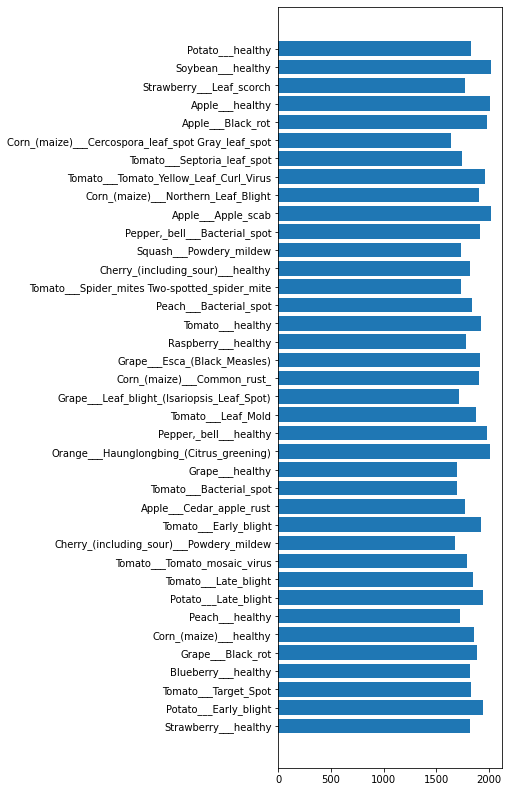

In [22]:
def compute_class_dist(path):
  """Returns the distribution of samples per class.

  Args:
    path: str. The path to either the training or validation data.

  Returns: dict. The classes are mapped to the number of samples present for
  that class.
  """
  # init the class dist
  class_dist = dict()
  # loop over all the classes
  for class_dir in glob(f"{path}/*"):
    # shorten the name of the class_dir (to use as a key in the dict)
    class_type = class_dir.split("/")[-1]
    # map the class to its number of samples
    class_dist[class_type] = (
        len(glob(f"{class_dir}/*")) # the number of images for a given class
    )
  # return the dist
  return class_dist


# visualize the class distribution using Matplotlib
class_dist = compute_class_dist(TRAIN_PATH)
plt.figure(figsize=(4,14))
plt.barh(list(class_dist.keys()), list(class_dist.values()))
plt.show()

Nope. Looks like there is definitely some classes that have more images than others. Therefore we may consider upsampling the minority classes if we observe that the model's overfitting to one class more than another.

## Examples of the Data

Let's pull out some of the training images (100 to be exact):

In [40]:
# get a tiny subset of the training images
train_dirs = glob(f"{TRAIN_PATH}/*")
X_train, y_train = list(), list()
# pick a random class
for _ in range(10):
  dir_index = random.randint(0, 36)
  class_path = train_dirs[dir_index]  # path to the dir of class images
  class_label = class_path.split("/")[-1]  # the label name itself
  # pick random images from that class
  for _ in range(10):
    sample_index = random.randint(0, len(glob(f"{class_path}/*")) - 2)
    # add the sample to the data subset
    sample_input = glob(f"{class_path}/*")[sample_index]
    X_train.append(sample_input)
    y_train.append(class_label)

If we wanted to plot many images, we could use something like this:

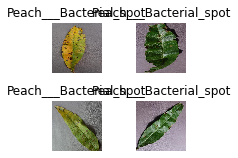

In [39]:
def plot_example_images(n_rows, n_cols, 
                        X_train, y_train, 
                        class_names):
  """Plots several examples of images in the dataset.

  We plot a grid of n_rows x n_cols, using example images from
  the training data. We will also save the plot, using the given name.

  Args:
    n_rows: int
    n_cols: int
    X_train: array-like object containing the images
    y_train: array-like object containing the labels (as strs)

  Returns: None
  """
  plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
  for row in range(n_rows):
      for col in range(n_cols):
          index = n_cols * row + col
          plt.subplot(n_rows, n_cols, index + 1)
          img = np.array(Image.open(X_train[index]))
          plt.imshow(img, interpolation="nearest")
          plt.axis('off')
          class_name = y_train[index]
          plt.title(class_name, fontsize=12)
  plt.subplots_adjust(wspace=0.7, hspace=0.5)
  plt.show()


# get the class names
class_names = [
  name.split("/")[-1] for name in glob(f"{TRAIN_PATH}/*")
]
# show 4 images
n_rows = 2
n_cols = 2
# make the plot 
plot_example_images(
    n_rows, n_cols, 
    X_train, y_train,  
    class_names
)

But it's a little hard to read, so we'll also print 1 image and see it's dimensions for now:

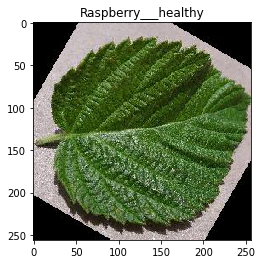

The dimensions of the image are: (256, 256, 3).


In [46]:
# get the image
img_index = 97
img = np.array(Image.open(X_train[img_index]))
# show the image and it's label
plt.imshow(img, interpolation="nearest")
class_name = y_train[img_index]
plt.title(class_name, fontsize=12)
plt.show()
# get the dimensions of the image
IMAGE_SIZE = img.shape
print(f"The dimensions of the image are: {IMAGE_SIZE}.")

# Defining the CNN Architecture
This model is an example of a CNN (*convolutional neural network*). 

We will be using the Sequential API in this implementation. The architecture is summarized below:

- 3 Convolutional Layers, 4 neurons each
- 1 Dense layer
- Optimizer Algorithm is Adam
- Drop Out Rate is 20%

### Utility Functions to Make Adding layers Easier

In [ ]:
def add_conv_layer(model, layer_size, needs_input, input_shape, kernel_size=None, pool_size=None):
    """Add a Keras convolutional layer to the model, along with MaxPooling.
       Will specify input shape as well if needed.
       
       Parameters:
       model(Model): Neural network in Keras
       layer_size(int): number of neurons to go in layer
       need_input(bool): signals if the convolutional layer needs to specify
                         the dimensions of the input
       input_shape(tuple or list): 1D vector of what the dataset dimensions are
       kernel_size(tuple): specifies a square matrix to use for kernel dimensions
       pool_size(tuple): specifies a square matrix to use in pooling
       
       Returns: None
       
    """
    # set kernel and pool size
    if kernel_size is None:
        kernel_size = (3, 3)
    if pool_size is None:
        pool_size = (2, 2)
    # specify input dimension for 1st conv layer
    if needs_input is True:
        conv_layer = Conv2D(layer_size,
                            kernel_size=kernel_size,
                            activation='relu',
                            input_shape=input_shape)

    else:
        # otherwise all other convolutional layers don't need it
        conv_layer = Conv2D(layer_size,
                            kernel_size=kernel_size,
                            activation='relu')
    # add Convolutional layer
    model.add(conv_layer)  
    # add MaxPooling layer
    model.add(MaxPooling2D(pool_size=pool_size))  # no learning params
    return None
                  
    
def add_dense_layer(model, layer_size, is_output, drop_rate):
    """Add a multi-layer perceptron to the model
       Will specify 'softmax' for the final layer.
       
       Parameters:
       model(Model): Neural network in Keras
       layer_size(int): number of neurons to go in layer
       is_output(bdool): signals if the MLP is the last layer
       drop_rate(float): percentage of connections in Dense layer
                       to cut off
       
       Returns: None
       
    """
    # specify activation function
    activation = 'relu' if is_output is False else 'softmax'
    # add MLP
    model.add(Dense(layer_size, activation=activation)) 
    # Add Dropout layer and Batch Normalization
    if is_output is False:
        model.add(BatchNormalization())
        model.add(Dropout(drop_rate))
    return None


def compile_model(model, optimizer=None):
    """Compile the neural network.
    
       Parameter:
       model(keras.Sequential or keras.Model): the model object
       optimizer(str): specfies the algoritm used to minimize loss
       
       Returns: None
       
    """
    # set the optimizer
    if optimizer is None:
        optimizer = 'adam'
    # compile the model
    model.compile(
        loss='categorical_crossentropy', optimizer=optimizer,
        metrics=[
          'accuracy', tf.keras.metrics.Precision(),
          tf.keras.metrics.Recall()]
    )
    return None

def define_model(units, conv_layers, dense_layers, dropout, input_shape):
    """Define a CNN + MLP model in Keras.
    
       Parameters:
       units(int): number of neurons to go in a layer
       conv_layers(int): number of convolutional layers
       dense_layers(int): number of MLP
       dropout(float): percentage of connections in the Dense layer(s) to cut 
        input_shape(tuple or list): 1D vector of what the dataset dimensions are
                       
       Returns: tf.keras.Sequential: the neural network to train
    
    """
    # Instaniate model
    model = Sequential()
    # Add CNN layers
    add_conv_layer(model, units, True, input_shape)
    for l in range(conv_layers - 1):
        # add convolutional layers that come after the 1st
        add_conv_layer(model, units, False, input_shape)
    # Flatten the data
    model.add(Flatten())
    # Add MLP Layers
    for l in range(dense_layers - 1):
        add_dense_layer(model, units, False, dropout)
    # add final MLP, for output
    add_dense_layer(model, NUM_CLASSES, True, dropout)
    # Compile Model
    compile_model(model)
    return model

### Instantiation of the Model

In [ ]:
# build the model
conv_layers = 3
dense_layers = 1
layer_size = 4

# Define Model
model = define_model(layer_size, conv_layers, dense_layers, 0.2, IMAGE_SIZE)

## Summarize the Model

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 4)       112       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 4)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 4)       148       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 4)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 4)         148       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2704)             

## Set the Training Parameters

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

### Use Data Generators
Due to the size of the dataset (87K images), this step will make the training process more efficient.

We scale all the data, and data augmentation is only on the training data (to make the model more robust).

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255, shear_range=0.2,
    zoom_range=0.2, horizontal_flip = True,
    validation_split=0.2  # set aside some data for validation
  )

test_datagen = ImageDataGenerator(rescale = 1./255)

### Load the Train, Test, and Validation Sets
We scale all the data, and data augmentation is only on the training data (to make the model more robust).

In [ ]:
# Make sure you provide the same target size as initialized for the image size
image_width, image_height = IMAGE_SIZE[0], IMAGE_SIZE[1]
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(image_width, image_height),
    batch_size=80, class_mode='categorical',
    subset='training'
  )

Found 56316 images belonging to 38 classes.


In [ ]:
# use the rest of the train/ dir for validation data
image_width, image_height = IMAGE_SIZE[0], IMAGE_SIZE[1]
val_set = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(image_width, image_height),
    batch_size=80, class_mode='categorical',
    subset='validation'
  )

Found 14059 images belonging to 38 classes.


In [ ]:
# use the valid/ dir for testing data
image_width, image_height = IMAGE_SIZE[0], IMAGE_SIZE[1]
test_set = test_datagen.flow_from_directory(
    VAL_PATH, target_size=(image_width, image_height),
    batch_size=80, class_mode='categorical' 
)

Found 17601 images belonging to 38 classes.


### Using Keras Callbacks

In [ ]:
# use TensorBoard to monitor training
# name the model for TensorBoard
NAME = (
    f'{3}-conv-{4}-nodes' +
    f'-{1}-dense_layers'
)
# Instantiate TensorBoard to visualize model performance
tensorboard = TensorBoard(log_dir=f'./Graph/{NAME}')

# using ModelCheckpoint, for convenience of coming back to train more later
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # we'll need to remake the architecture again
    monitor='accuracy',
    mode='max',
    save_freq='epoch',  # save every epoch
    save_best_only=True)

## Train the Model

In [ ]:
while True:  # preventing runtime timeout
  history = model.fit(
      x=training_set,  # pass in the generator to determine x, y, and batch_size
      epochs=3, validation_data=val_set,
      steps_per_epoch=len(training_set),
      validation_steps=len(val_set),
      callbacks=[
        tensorboard, model_checkpoint_callback
      ]
  )
  break

Epoch 1/3
704/704 [==============================] - ETA: 0s - loss: 2.1093 - accuracy: 0.4049

## Evaluate the Model

In [ ]:
def plot_metric(history, metric):
    """Plots the model performance metric for training
       testing data using Matplotlib.
       
       Parameters
       history(History): contains data on model's metrics over the
                         course of the training
       metric(str): the name of the metric. Will be one of 
                    the keys in the History object, e.g. 'loss'
       
       Returns: None
       
    """
    # plot for training data
    plt.plot(history.history[metric])
    # plot for testing data
    val_form = f'val_{metric}'
    plt.plot(history.history[val_form])
    # add meta-info about graph - title, labels, legend
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # show the graph
    plt.show()
    return None


NameError: ignored

In [ ]:
# TODO: plot validation accuracy 

In [ ]:
# TODO plot validation loss

## Export the Model

In [ ]:
def save_model(model, weights_file, architecture_file):
    """Save the model weights and architecture.
    
       Parameters: 
       model(Model): keras Model object being saved
       weights_file(str): name of the Hadoop file where
                          weights will be saved
       architecture_file(str): name of the JSON file where 
                               model architecture is to be
                               saved
                               
       Returns: None
       
    """
    # Save the weights
    model.save_weights(f'{weights_file}.h5')
    # Save the architecture
    with open(f'{architecture_file}.json', 'w') as f:
        f.write(model.to_json())
    return None

# TODO: save the model architecture in JSON, and the weights in a Hadoop file

## Final Conclusions

## Next Steps

1. Use [TensorBoard](https://www.ecosia.org/search?q=tensorboard&addon=chrome&addonversion=3.2.0&method=topbar) and [Hyperas](https://github.com/maxpumperla/hyperas/issues) to experiment with what the best architecture and hyperparameters to experiment with what the best hyperparameters are for the model.
2. Check for class imbalances, and if there are try to upsample the minority classes (or adjust the class weights) in order to address the issue.
3. Try using pre-trained weights from a popular CNN like ResNet or Inception, and see if we get a better performing model.